In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsplus as stp

# plt.rcParams.keys()
plt.rcParams.update({"font.family": "Times New Roman", "mathtext.fontset": "cm"})

In [2]:
def gauss_mu_sigma(x, mu: float = 0, sigma: float = 1):
    return np.e**(-((x - mu) / sigma)**2 / 2) / (np.sqrt(2 * np.pi) * sigma)

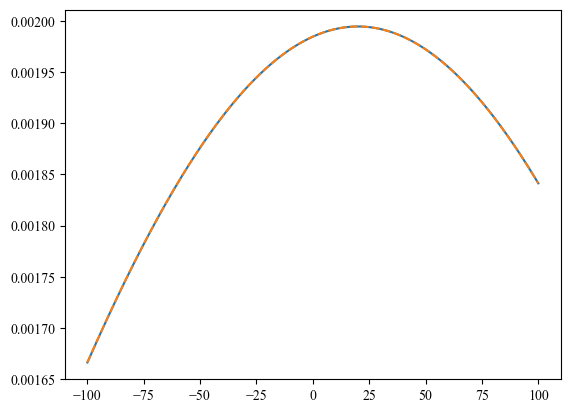

In [3]:
fig, ax = plt.subplots()
x = np.linspace(-100, 100, 1000)
ax.plot(x, gauss_mu_sigma(x, 20, 200))
ax.plot(x, stats.norm.pdf(x, 20, 200), linestyle = "--")

In [4]:
def get_gauss_data_bins(mu, sigma, num_samples = 1000):
    X = np.random.normal(mu, sigma, num_samples)
    bin_edges = [0.5 * x - 0.25 for x in range(22)]
    occurrences, edges = np.histogram(X, bins = bin_edges)
    bin_centers = [(min + max) / 2 for min, max in zip(bin_edges[:-1], bin_edges[1:])]
    return X, bin_centers

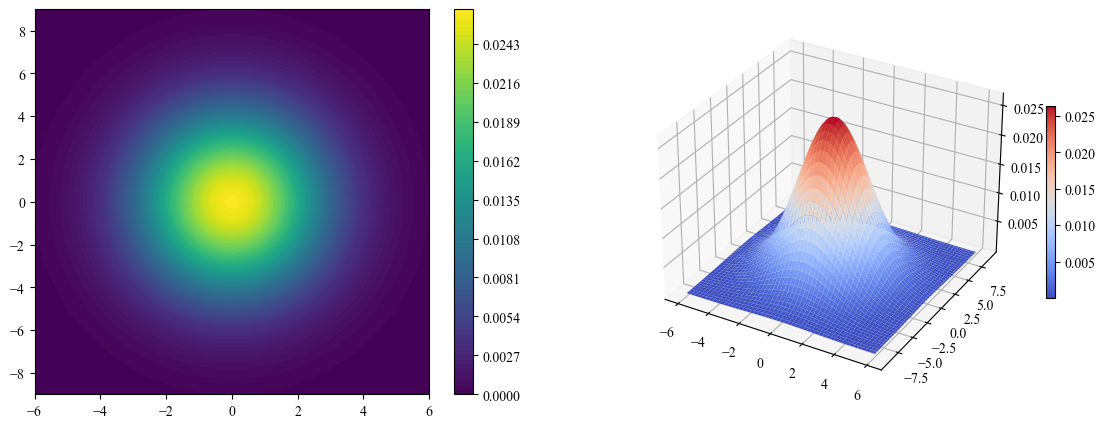

In [5]:
from matplotlib import cm

# Joint probability
def mult_gauss_mu_sigma(x, y, mux, sigmax, muy, sigmay):
    return gauss_mu_sigma(x, mux, sigmax) * gauss_mu_sigma(y, muy, sigmay)

mux, muy = [0, 0]
sigmax, sigmay = [2, 3]
x = np.linspace(mux - 3 * sigmax, mux + 3 * sigmax, 100)
y = np.linspace(muy - 3 * sigmay, muy + 3 * sigmay, 100)
X, Y = np.meshgrid(x, y)
Z = mult_gauss_mu_sigma(X, Y, mux, sigmax, muy, sigmay)

fig = plt.figure(figsize = (14, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection = '3d')

CT = ax1.contourf(X, Y, Z, 100)
plt.colorbar(CT)
surf = ax2.plot_surface(X, Y, Z, cmap = cm.coolwarm)
plt.colorbar(surf, shrink = 0.5)

In [99]:
from scipy.special import factorial

# Generating poisson events
def generate_event_times(num_events, time_range):
    return np.random.random(num_events) * time_range


@np.vectorize
def get_events_in_between(time_min, time_max, num_events, time_range):
    event_times = generate_event_times(num_events, time_range)
    filter_array = time_min<= event_times <= time_bound
    return len(event_times[filter_array])


@np.vectorize
def get_events_in_time(time_bound, num_events, time_range):
    event_times = generate_event_times(num_events, time_range)
    filter_array = event_times <= time_bound
    return len(event_times[filter_array])


@np.vectorize
def get_avg_events_in_time(time_bound, num_events, time_range):
    toys = 100
    events_within_time_bound_avg = 0
    for i in range(toys):
        event_times = generate_event_times(num_events, time_range)
        filter_array = event_times <= time_bound
        events_within_time_bound_avg += len(event_times[filter_array])
    return events_within_time_bound_avg / toys


def count_events_per_unit_time(num_events, time_range):
    np.array([k for k in get_events_in_between()])


@np.vectorize
def Poisson_PMF(num_events, time_range, time_interval, k):
    # Lambda value
    if k < 0:
        return 0
    lamb = num_events * time_interval / time_range
    return np.e**(-lamb) * lamb**k / factorial(k)

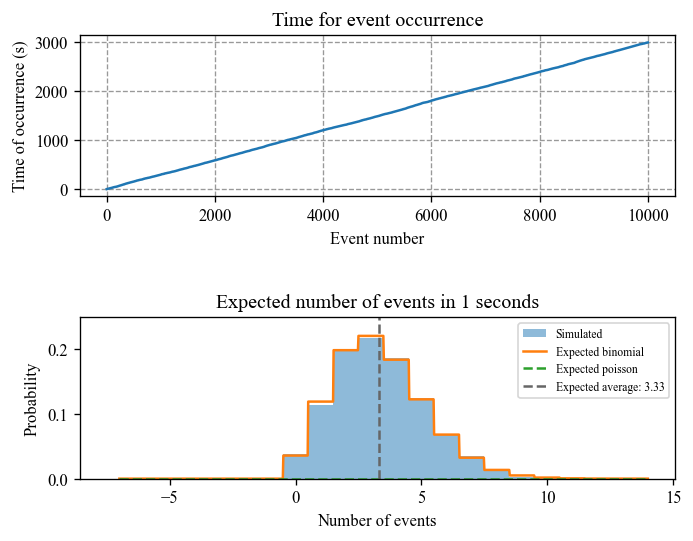

In [100]:
n = 10000
time_range = 3000
time_interval = 1 # s

events_per_second = n / time_range
# Expected number of events in interval
lamb = time_interval * events_per_second
number_intervals = 1 + time_range // time_interval
p = time_interval / time_range # Probability of falling in time_interval second bins
event_times = np.sort(generate_event_times(n, time_range))

fig, axs = plt.subplots(2, dpi = 120)
axs[0].plot(event_times)
axs[0].set(title = "Time for event occurrence", xlabel = "Event number", ylabel = "Time of occurrence (s)")

# Occurrences per time interval
bins = [time_interval * n for n in range(number_intervals)]
occurrences, edges = np.histogram(event_times, bins = bins)

# Simulated number of events in  second
plot_range = (int(lamb - 6 * np.sqrt(lamb)), int(lamb + 6 * np.sqrt(lamb)))
bins = [n - 0.5 for n in
        range(*plot_range)]
# Normalizing occurrences
stp.hist_to_pmf(axs[1], occurrences, bins = bins, alpha = 0.5, label = "Simulated")

# Expected number of events in one second
x = np.linspace(*plot_range, 1000)
axs[1].plot(x, stats.binom.pmf(np.floor(x + 0.5), n, p), label = "Expected binomial")
axs[1].plot(x, Poisson_PMF(n, time_range, time_interval, np.floor(x + 0.5)), linestyle = "--", label = "Expected poisson")
axs[1].axvline(lamb, linestyle = "--", color = "#666", label = f"Expected average: {round(lamb, 2)}")

# Axs1 format
axs[1].set(title = f"Expected number of events in {time_interval} seconds", xlabel = "Number of events", ylabel = "Probability")
axs[1].legend(fontsize = 7)

axs[0].grid(linestyle = "--", color = "#999")
plt.subplots_adjust(hspace = 0.75)

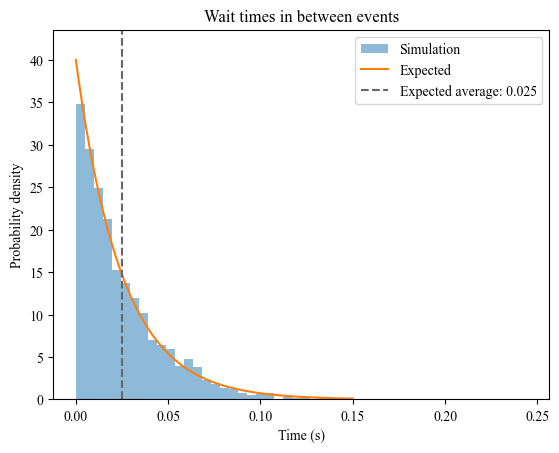

In [101]:
n = 2000
time_range = 50
avg_wait_time = 1 / (n / time_range)
event_times = np.sort(generate_event_times(n, time_range))
wait_times = [t1 - t0 for t0, t1 in zip(event_times[:-1], event_times[1:])]

fig, ax = plt.subplots()
# Simulation
nbins = 50
stp.hist_to_pdf(ax, wait_times, bins = nbins, label = "Simulation", alpha = 0.5)

# Expected
x = np.linspace(0, avg_wait_time + 5 * avg_wait_time, 1000)
ax.plot(x, stats.expon.pdf(x, 0, avg_wait_time), label = "Expected")
ax.axvline(avg_wait_time, linestyle = "--", color = "#666", label = f"Expected average: {round(avg_wait_time, 5)}")
ax.set(title = "Wait times in between events", xlabel = "Time (s)", ylabel = "Probability density")
ax.legend()